**Importing Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
import zipfile
from PIL import Image

**Implementing a U-Net Style generator from scratch.**

In [2]:
# Defining the Generator (U-Net Style)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Implementing a PatchGAN discriminator.**

In [3]:
# Defining the Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


**Initializing the models**

In [4]:
# Initialize Models
generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss Functions and Optimizers
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0008, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0008, betas=(0.5, 0.999))

**Preparing the datset for training**

In [5]:
# Dataset Preparation
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_path = '/kaggle/input/gan-getting-started/'

photos_path = os.path.join(data_path, 'photo_jpg')
monet_path = os.path.join(data_path, 'monet_jpg')

photo_files = [os.path.join(photos_path, file) for file in os.listdir(photos_path)]
monet_files = [os.path.join(monet_path, file) for file in os.listdir(monet_path)]


**Preprocessing the Images from the dataset**

In [6]:
class FlatImageDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

photo_dataset = FlatImageDataset(photo_files, transform=data_transforms)
monet_dataset = FlatImageDataset(monet_files, transform=data_transforms)

photo_loader = DataLoader(photo_dataset, batch_size=32, shuffle=True)
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True)

**Training the dataset with the images,gave it 30 epochs**

In [7]:
# Training Loop
num_epochs = 30  
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        # Move data to device
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        # Print Progress
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

Epoch [1/30], Batch [0], G_Loss: 2.2757599353790283, D_Loss: 0.48577019572257996
Epoch [2/30], Batch [0], G_Loss: 1.4097342491149902, D_Loss: 0.25048792362213135
Epoch [3/30], Batch [0], G_Loss: 1.1789875030517578, D_Loss: 0.24027791619300842
Epoch [4/30], Batch [0], G_Loss: 1.0317158699035645, D_Loss: 0.2831314206123352
Epoch [5/30], Batch [0], G_Loss: 0.8061129450798035, D_Loss: 0.2237279713153839
Epoch [6/30], Batch [0], G_Loss: 0.6442028284072876, D_Loss: 0.25156837701797485
Epoch [7/30], Batch [0], G_Loss: 0.7234001755714417, D_Loss: 0.24017485976219177
Epoch [8/30], Batch [0], G_Loss: 0.6201613545417786, D_Loss: 0.24802842736244202
Epoch [9/30], Batch [0], G_Loss: 0.7787877321243286, D_Loss: 0.3554062843322754
Epoch [10/30], Batch [0], G_Loss: 0.678610622882843, D_Loss: 0.23438724875450134
Epoch [11/30], Batch [0], G_Loss: 0.7115457057952881, D_Loss: 0.27656131982803345
Epoch [12/30], Batch [0], G_Loss: 0.6765806674957275, D_Loss: 0.21381232142448425
Epoch [13/30], Batch [0], G_L

**Visualising the predictions**

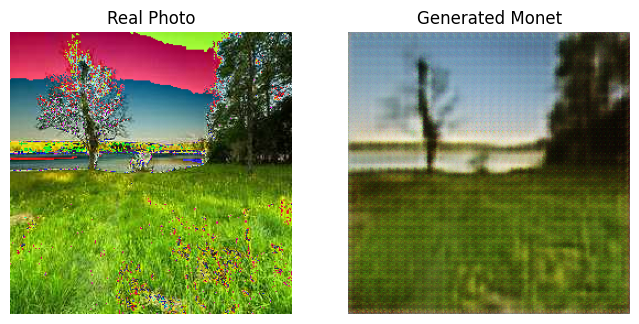

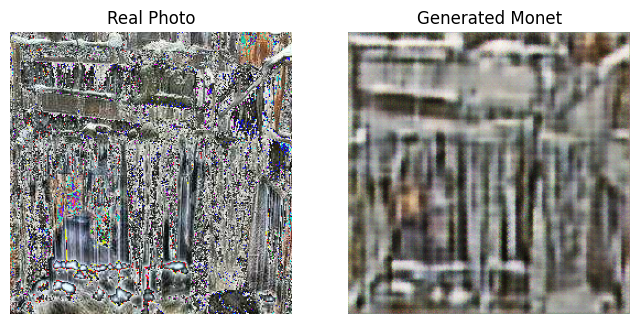

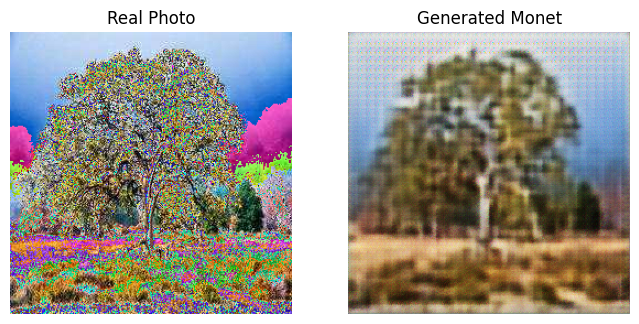

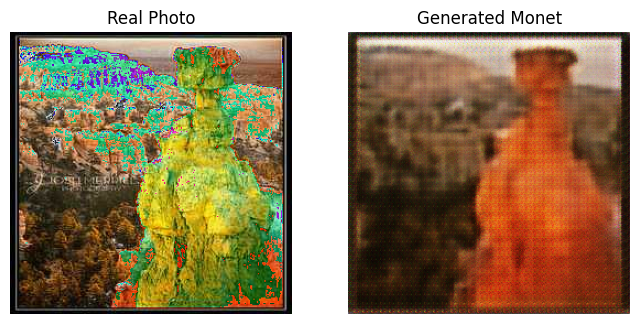

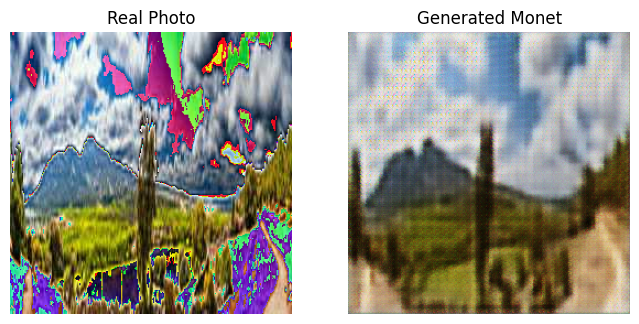

In [8]:
import matplotlib.pyplot as plt
def visualize_predictions(loader, generator, num_images=5):
    generator.eval()
    with torch.no_grad():
        for i, photo_batch in enumerate(loader):
            real_photos = photo_batch.to(device)
            fake_monets = generator(real_photos)
            fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

            for j in range(min(num_images, len(fake_monets))):
                real_img = transforms.ToPILImage()(real_photos[j].cpu())
                fake_img = transforms.ToPILImage()(fake_monets[j].cpu())

                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title("Real Photo")
                plt.imshow(real_img)
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Generated Monet")
                plt.imshow(fake_img)
                plt.axis("off")
                plt.show()

                num_images -= 1
                if num_images <= 0:
                    return

visualize_predictions(photo_loader, generator)
